# Video inference position estimation

using the od of our model on a new image and a simple projective model

# Select a model for inference

In [1]:
import tensorflow as tf
import larq as lq

# import custom modules
from utils.processing_tools import *
from utils.generators import *
from utils.model_tools import *


import pyximport
pyximport.install(reload_support=True)
from utils.evaluate import *


In [2]:
import infer

We will use the arguments from the inference file

In [3]:
args =  ['--architecture', 'resnet50_centernet', '--gpu', '5', '--dataset-path', '../../datasets/PascalVOC/', '--model-weights-path', 'saved_models/resnet50_centernet/resnet50_centernet_model.h5']
# on the inference script we use: args = sys.argv[1:]
args = infer.parse_args(args)

{'architecture': 'resnet50_centernet', 'batch_size': 32, 'num_classes': 20, 'input_size': 512, 'gpu': '5', 'model_summary': True, 'dataset_path': '../../datasets/PascalVOC/', 'model_weights_path': 'saved_models/resnet50_centernet/resnet50_centernet_model.h5'}


Now we get the parsed args

In [4]:
num_classes = args.num_classes
input_size = (args.input_size,args.input_size)
#assert input_size[0] == input_size[1], "Input shape must be the same"
batch_size = args.batch_size
# optionally choose specific GPU
if args.gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
# CHECK GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('problem loading gpu')
import importlib
sys.path.append('architectures')
#import architecture module
architecture_module = importlib.import_module(args.architecture)

# set architecture name
architecture_name = args.architecture

Default GPU Device: /device:GPU:0


Instantiate a model and download weights

In [5]:
# create model given an architecture
# (the centernet input must be specified by the architecture file)
model, prediction_model, debug_model = architecture_module.centernet(input_size = input_size, num_classes = num_classes)

try:
    model.load_weights(args.model_weights_path)
    print("Model loaded!")
except:
    print("Error: Failed loading model from weights...")
    #sys.exit(1)

# compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss={'centernet_loss': lambda y_true, y_pred: y_pred})

if args.model_summary:
    lq.models.summary(model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model loaded!
+model stats--------------------------------------------------------------------------------+
| Layer                  Input prec.              Outputs  # 32-bit     Memory  32-bit MACs |
|                              (bit)                            x 1       (kB)              |
+-------------------------------------------------------------------------------------------+
| input_1 

Open the validation dataset and instantiate a generator

# Video Inference Function

In [18]:
# inference image
def img_inference(image, pred_model, num_classes, score_threshold = 0.1, 
                    save_img = False, plot_img = True, figsize = (15,15), infer_time = True):
    
    colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]

    classes = list(img_generator.classes.keys())
    # create directory if it doesn't exist
    if save_img:
        if not os.path.isdir('tests'):
            os.mkdir('tests')
            
    # preprocess image     
    src_image = image.copy()
    
    c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
    s = max(image.shape[0], image.shape[1]) * 1.0

    tgt_w = img_generator.input_size
    tgt_h = img_generator.input_size
    image = img_generator.preprocess_image(image, c, s, tgt_w=tgt_w, tgt_h=tgt_h)

    inputs = np.expand_dims(image, axis=0)
    
    # run network
    start = time.time()
    detections = pred_model.predict_on_batch(inputs)[0]
    delta_t = time.time() - start
    
    if infer_time:
        print('Inference time : ', delta_t)
    
    # get scores
    scores = detections[:, 4]


    # select indices which have a score above the threshold
    indices = np.where(scores > score_threshold)[0]

    # select those detections
    detections = detections[indices]
    detections_copy = detections.copy()
    detections = detections.astype(np.float64)
    trans = get_affine_transform(c, s, (tgt_w // 4, tgt_h // 4), inv=1)

    for j in range(detections.shape[0]):
        detections[j, 0:2] = affine_transform(detections[j, 0:2], trans)
        detections[j, 2:4] = affine_transform(detections[j, 2:4], trans)

    detections[:, [0, 2]] = np.clip(detections[:, [0, 2]], 0, src_image.shape[1])
    detections[:, [1, 3]] = np.clip(detections[:, [1, 3]], 0, src_image.shape[0])
    for detection in detections:
        xmin = int(round(detection[0]))
        ymin = int(round(detection[1]))
        xmax = int(round(detection[2]))
        ymax = int(round(detection[3]))
        score = '{:.4f}'.format(detection[4])
        class_id = int(detection[5])
        color = colors[class_id]
        class_name = classes[class_id]
        label = '-'.join([class_name, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    if save_img:
        image_fname = img_generator.image_names[idx]
        cv2.imwrite('tests/{}.jpg'.format(image_fname), src_image)
    if plot_img:
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(src_image)
        plt.axis('off')
        plt.show()

In [19]:
#############################################################
#
#    Image inference function
#
#############################################################

voc_classes = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

def preprocess_image(image, c, s, tgt_w, tgt_h):
        trans_input = get_affine_transform(c, s, (tgt_w, tgt_h))
        image = cv2.warpAffine(image, trans_input, (tgt_w, tgt_h), flags=cv2.INTER_LINEAR)
        image = image.astype(np.float32)

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68

        return image

# inference directly from an image stored in RAM
def image_direct_inference(image, pred_model, colors, score_threshold = 0.1, 
                           output_name = 'image_output',
                    save_img = False, plot_img = False, figsize = (15,15), verbose = 0,
                    classes = voc_classes, input_w = 512, input_h = 512):
    """
    Extract object detection predictions from a model.

    :image: image file
    :pred_model: model used for predicting bounding boxes
    :colors: colors to use in plot
    :score_threshold: minimum confidence to accept detection
    :plot_img: set to True to plot image with matplotlib
    :output_name: set output image name
    :save_img: set to true to save image with detections to /output
    :figsize: set size for plot if plot_img is True
    :classes: dictionary with classes used by the detector
    :input_w: input width
    :input_h: input lehgth
    :verbose: disable to silence function prints
    
    :return: array of detections
    """ 
    
    tgt_w=input_w
    tgt_h=input_h
    

    classes_list = list(classes.keys())
    
    # create directory if it doesn't exist
    if save_img:
        if not os.path.isdir('output'):
            os.mkdir('output')
    
    # copy image
    src_image = image.copy()
    
    # get center and scale of the image
    c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
    s = max(image.shape[0], image.shape[1]) * 1.0

    # preprocess image
    image = preprocess_image(image, c, s, tgt_w=tgt_w, tgt_h=tgt_h)
    inputs = np.expand_dims(image, axis=0)
    
    # run network
    start = time.time()
    detections = pred_model.predict_on_batch(inputs)[0]
    delta_t = time.time() - start
    
    if verbose > 0:
        print('Inference time : ', delta_t)
    
    # get scores
    scores = detections[:, 4]

    # select indices which have a score above the threshold
    indices = np.where(scores > score_threshold)[0]

    # select those detections
    detections = detections[indices]
    detections_copy = detections.copy()
    detections = detections.astype(np.float64)
    
    # obtain detection transformation to original image size
    trans = get_affine_transform(c, s, (tgt_w // 4, tgt_h // 4), inv=1)

    for j in range(detections.shape[0]):
        detections[j, 0:2] = affine_transform(detections[j, 0:2], trans)
        detections[j, 2:4] = affine_transform(detections[j, 2:4], trans)

    detections[:, [0, 2]] = np.clip(detections[:, [0, 2]], 0, src_image.shape[1])
    detections[:, [1, 3]] = np.clip(detections[:, [1, 3]], 0, src_image.shape[0])
    
    if plot_img:
        for detection in detections:
            xmin = int(round(detection[0]))
            ymin = int(round(detection[1]))
            xmax = int(round(detection[2]))
            ymax = int(round(detection[3]))
            score = '{:.4f}'.format(detection[4])
            class_id = int(detection[5])
            color = colors[class_id]
            class_name = classes_list[class_id]
            label = '-'.join([class_name, score])
            ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
            cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
            cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(src_image)
        plt.axis('off')
        plt.show()
    
    if save_img:
        cv2.imwrite(os.path.join('output',output_name), src_image)
        
    return detections

# Test with sample video footage

ref: https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

## Get .mp4 files

In [20]:
video_path = os.path.join('..','..','datasets','NokiaVillarceauxVideoFeed')
video_path

'../../datasets/NokiaVillarceauxVideoFeed'

In [21]:
!ls '../../datasets/NokiaVillarceauxVideoFeed'

BOU  GAL  GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4


In [22]:
filenames = []
dirnames = []
for (_dirpath, _dirnames, _filenames) in os.walk(video_path):
    filenames.extend(_filenames)
    dirnames.extend(_dirnames)
    break

In [23]:
filepath = os.path.join(video_path, filenames[0])
filepath

'../../datasets/NokiaVillarceauxVideoFeed/GAL-EXT-NORD-OUEST_2022-06-01_08h44min22s120ms.mp4'

## Processing footage

In [24]:
import numpy as np
import cv2 
import os

In [25]:
# extract between different frames blocks
def print_frames(path_in, max_it = 5, speed = 1, plot_img = True , figsize = (15,15), verbose = True):
    """
    print or save video frames as images using cv2.

    :path_in: video file path
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :verbose: disable to silence function prints
    """ 
    count = 0
    vidcap = cv2.VideoCapture(path_in)
    success,image = vidcap.read()
    success = True
    while success:
        frame_number = count*speed
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(frame_number))    # added this line 
        success,image = vidcap.read()
        if verbose:
            print ('Read a new frame: {}, frame = {} , iteration = {}'.format(success, frame_number, count))
        
        src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if plot_img:
            plt.figure(figsize=figsize)
            plt.imshow(src_image)
            plt.axis('off')
            plt.show()
        
        count = count + 1
        if count >= max_it:
            break


## Object detection on video feed

In [56]:
# OD on different frames blocks
def video_od(pred_model, path_in, classes = voc_classes, max_it = 5, speed = 1, 
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :pred_model: object detection model
    :path_in: video file path
    :classes: dict of classes used by the model to predict
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
    
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
    
    predictions = []
    

    
    count = 0
    vidcap = cv2.VideoCapture(path_in)
    
    if verbose > 0:
         # Convert the resolutions from float to integer.
        frame_width = int(vidcap.get(3))
        frame_height = int(vidcap.get(4))
        print ('Video width: {}, video heigth = {}'.format(frame_width, frame_height))
    
    success,image = vidcap.read()
    success = True
    while success:
        frame_number = count*speed
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(frame_number))    # added this line 
        success,image = vidcap.read()
        if verbose > 0:
            print ('Read a new frame: {}, frame = {} , iteration = {}'.format(success, frame_number, count))
        
        src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pred = image_direct_inference(image, pred_model, colors, verbose = verbose, plot_img = plot_img, figsize = figsize)
        predictions.append(pred)
        count = count + 1
        if count >= max_it:
            break
        
    return predictions

## Generating Video Predictions

In [29]:
# OD on different frames blocks outputing video
def generate_video_od(pred_model, path_in, out_name, out_dim = (1024,576), classes = voc_classes, max_frames = 1e4, speed = 1, 
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :pred_model: object detection model
    :path_in: video file path
    :out_name: name of the output video file
    :out_dim: output dimension of the video (std = 1024,576)
    :classes: dict of classes used by the model to predict
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
    
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(num_classes)]
    
    predictions = []
    
    # Get class names in string format
    classes = list(classes.keys())
    
    # create directory if it doesn't exist
    if not os.path.isdir('output'):
        os.mkdir('output')
    
    # Open and process video using cv2
    vidcap = cv2.VideoCapture(path_in)
    success,image = vidcap.read()
    success = True
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))

    property_id = int(cv2.CAP_PROP_FRAME_COUNT) 
    video_fps = vidcap.get(cv2.CAP_PROP_FPS)

    # Process subset or whole video
    nframes = int(cv2.VideoCapture.get(vidcap, property_id))
    nprocess = min(nframes, max_frames)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    
    # Select output format
    out = cv2.VideoWriter(os.path.join('output', out_name + '.mp4'), fourcc, video_fps, out_dim)
    
    
    if verbose >= 1:
        print("Video original framerate is {}".format(video_fps))
        print("Video length consists of {} frames\n".format(nframes))
        if nprocess != nframes:
            print("Processing  {} frames\n\n".format(nprocess))
        
    
    count = 0
    while success and count < nprocess:
        
        frame_number = count*speed
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success,image = vidcap.read()
        
        if not success:
            break
            
        detections = image_direct_inference(image, pred_model, colors, plot_img = False, verbose = 0)

        #add bbox to frames
        for detection in detections:
            xmin = int(round(detection[0]))
            ymin = int(round(detection[1]))
            xmax = int(round(detection[2]))
            ymax = int(round(detection[3]))
            score = '{:.4f}'.format(detection[4])
            class_id = int(detection[5])
            color = colors[class_id]
            class_name = classes[class_id]
            label = '-'.join([class_name, score])
            ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
            cv2.rectangle(image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
            cv2.putText(image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        
        
        # write the OD frame
        out.write(cv2.resize(image, out_dim, interpolation = cv2.INTER_AREA))
        
        count = count + 1
        if verbose >= 2:
            pct = (count/nprocess)*100
            if pct%10 == 0:
                print("Processed {}% of frames".format(pct))

    # When everything done, release the video capture and video write objects
    vidcap.release()
    out.release()
    
    


## Heatmaps 

In [202]:
# inference directly from an image stored in RAM and optionally output hmaps
def hmap_direct_inference(image, debug_model, score_threshold = 0.1,
                           output_name = 'heatmap_output',
                    save_img = False, plot_img = False, figsize = (15,15), verbose = 0,
                    classes = voc_classes, input_w = 512, input_h = 512):
    """
    Extract object detection heatmap predictions from a model.

    :image: image file
    :pred_model: model used for predicting bounding boxes
    :colors: colors to use in plot
    :score_threshold: minimum confidence to accept detection
    :plot_img: set to True to plot image with matplotlib
    :output_name: set output image name
    :save_img: set to true to save image with detections to /output
    :figsize: set size for plot if plot_img is True
    :classes: dictionary with classes used by the detector
    :input_w: input width
    :input_h: input lehgth
    :verbose: disable to silence function prints
    
    :return: array of heatmaps
    """ 
    
    tgt_w=input_w
    tgt_h=input_h
    

    classes_list = list(classes.keys())
    
    # create directory if it doesn't exist
    if save_img:
        if not os.path.isdir('output'):
            os.mkdir('output')
    
    # copy image
    src_image = image.copy()
    
    # get center and scale of the image
    c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
    s = max(image.shape[0], image.shape[1]) * 1.0

    # preprocess image
    image = preprocess_image(image, c, s, tgt_w=tgt_w, tgt_h=tgt_h)
    inputs = np.expand_dims(image, axis=0)
    
    # run network
    start = time.time()
    heatmaps = heatmaps = debug_model.predict_on_batch(inputs)[0][0]
    delta_t = time.time() - start
    
    if verbose > 0:
        print('Inference time : ', delta_t)
    
    
    # obtain detection transformation to original image size
    trans = get_affine_transform(c, s, (tgt_w // 4, tgt_h // 4), inv=1)

    
    if plot_img:
        plt.figure(figsize=figsize)
        for idx in range(0,20):
            plt.subplot(4, 5, idx+1)
            plt.imshow(heatmaps[:,:,idx])
            title = 'class: ' + classes_list[idx]
            plt.title(title)
        
    return heatmaps

In [206]:
# for the moment extracts 1 fps
def video_hmaps(pred_model, num_classes, pathIn, classes_displayed = [6], pathOut = None, max_it = 5, figsize = (15,15), verbose = True):
    if pathOut is None:
        count = 0
        vidcap = cv2.VideoCapture(pathIn)
        success,image = vidcap.read()
        success = True
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
            success,image = vidcap.read()
            if verbose:
                print ('Read a new frame: ', success)
            #src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            hm = hmap_direct_inference(image, debug_model, num_classes, plot_img = False)
            count = count + 1
            plt.imshow(hm[:,:,classes_displayed[0]])
            plt.show()
            if count == max_it:
                break
            
            

In [234]:
# OD on different frames blocks outputing video
def generate_video_hm(debug_model, path_in, out_name, out_dim = (1024,576), classes = voc_classes, display_classes = [6],
                      max_frames = 1e4, speed = 1, plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :pred_model: debug object detection model
    :path_in: video file path
    :out_name: name of the output video file
    :out_dim: output dimension of the video (std = 1024,576)
    :classes: dict of classes used by the model to predict
    :display_classes: classes whose heatmaps will be displayed 
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
    
    
    
    # Get class names in string format
    classes_list = list(classes.keys())
    
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(len(classes_list))]
    
    # create directory if it doesn't exist
    if not os.path.isdir('output'):
        os.mkdir('output')
    
    # Open and process video using cv2
    vidcap = cv2.VideoCapture(path_in)
    success,image = vidcap.read()
    success = True
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))

    property_id = int(cv2.CAP_PROP_FRAME_COUNT) 
    video_fps = vidcap.get(cv2.CAP_PROP_FPS)

    # Process subset or whole video
    nframes = int(cv2.VideoCapture.get(vidcap, property_id))
    nprocess = min(nframes, max_frames)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    
    # Select output format for each class
    out_list = []
    for c in display_classes:
        class_path = os.path.join('output', out_name + '_' + classes_list[c] + '.mp4')
        out = cv2.VideoWriter(class_path, fourcc, video_fps, out_dim)
        out_list.append(out)
    
    
    if verbose >= 1:
        print("Video original framerate is {}".format(video_fps))
        print("Video length consists of {} frames\n".format(nframes))
        if nprocess != nframes:
            print("Processing  {} frames\n\n".format(nprocess))
        
    
    count = 0
    while success and count < nprocess:
        
        frame_number = count*speed
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success,image = vidcap.read()
        
        if not success:
            break
            
        hm = hmap_direct_inference(image, debug_model, num_classes, plot_img = False)
        
        
        
        
        # write the OD frame for each selected class
        for idx, c in enumerate(display_classes):
            
            # write heatmaps
            heatmap = hm[:,:,display_classes[idx]]
        
            heatmap = (heatmap * 255).astype(np.uint8)
            image = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
            
            out = out_list[idx]
            out.write(cv2.resize(image, out_dim, interpolation = cv2.INTER_AREA))
        
        count = count + 1
        if verbose >= 2:
            pct = (count/nprocess)*100
            if pct%10 == 0:
                print("Processed {}% of frames".format(pct))

    # When everything done, release the video capture and video write objects
    vidcap.release()
    for out in out_list:
        out.release()

# Position estimation

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2
import json
import time
import glob
import sys

In [12]:
def calculate_error(estimated_pos, gt_pos):
    return np.linalg.norm(np.array(estimated_pos) - np.array(gt_pos))/np.linalg.norm(np.array(gt_pos))*100

In [13]:
def plot_result_position(idx, imgs, anno, positions):
    img = imgs[idx]
    car_img_coords_a = get_bb_center(anno[idx]['bboxes'][0])
    car_img_coords_b = get_bb_center(anno[idx]['bboxes'][1])

    car_xy_coords_a = positions[idx][0]
    car_xy_coords_b = positions[idx][1]

    pos_car_a = get_vehicle_pos(car_img_coords_a)
    pos_car_b = get_vehicle_pos(car_img_coords_b)

    plot_2_cars_center(img, car_img_coords_a, car_img_coords_b)

    estimated_a_coords = np.array([camera_coords[0] + pos_car_a[0], camera_coords[1] -pos_car_a[1]])
    estimated_b_coords = np.array([camera_coords[0] + pos_car_b[0], camera_coords[1] -pos_car_b[1]])

    pos_a_error = calculate_error(estimated_a_coords, car_xy_coords_a)
    pos_b_error = calculate_error(estimated_b_coords, car_xy_coords_b)


    print("Red dot: ")
    print("XY car coordinates relative to camera: ", (pos_car_a[0],pos_car_a[1]))
    print("Estimated world car coordinates: ", estimated_a_coords)
    print("Real coordinates: ", car_xy_coords_a)
    print("Error : {} %".format(pos_a_error))

    print("\n")

    print("Yellow dot: ")
    print("XY car coordinates relative to camera: ", (pos_car_b[0],pos_car_b[1]))
    print("Estimated world car coordinates: ", estimated_b_coords)
    print("Real coordinates: ", car_xy_coords_b)
    print("Error : {} %".format(pos_b_error))

    print("\n")

    print("Relative car distance: ", np.linalg.norm(estimated_a_coords - estimated_b_coords), ' [m]')

Video width: 1920, video heigth = 1080
Read a new frame: True, frame = 0 , iteration = 0
Inference time :  0.03695368766784668


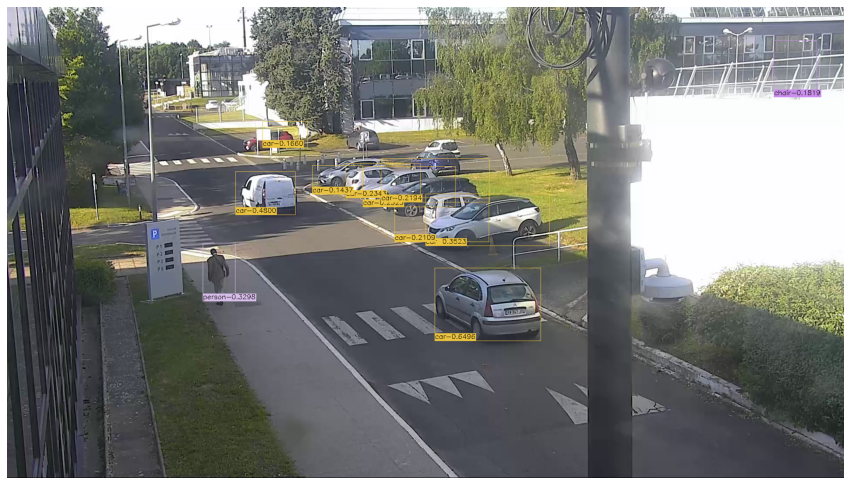

Read a new frame: True, frame = 1000 , iteration = 1
Inference time :  0.0386044979095459


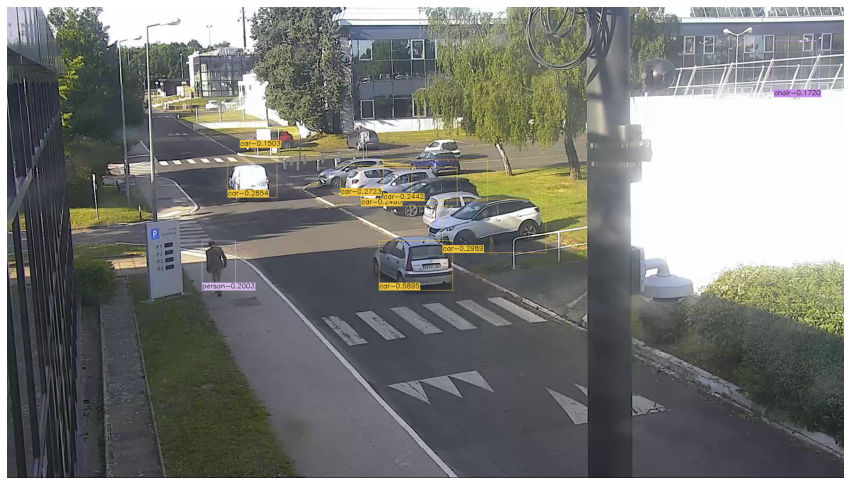

Read a new frame: True, frame = 2000 , iteration = 2
Inference time :  0.03486275672912598


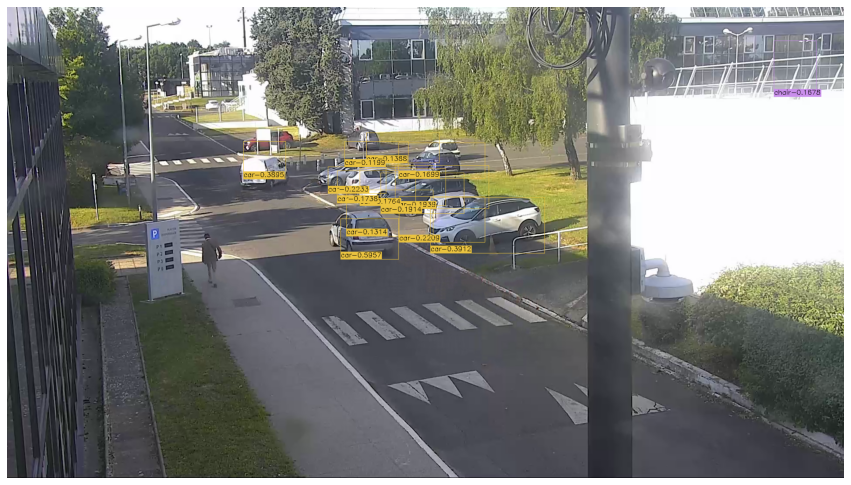

In [58]:
preds0 = video_od(prediction_model, filepath, max_it = 3, plot_img = True, figsize = (15,15), speed = 1000, verbose = 1)

# Let's analyse frame 2

In [124]:
# extract a frame
def get_frame(path_in, get_it = 1, max_it = 5, speed = 1, 
             plot_img = True , figsize = (15,15), verbose = 0):
    """
    delete
    """ 
    
    
    count = 0
    vidcap = cv2.VideoCapture(path_in)
    
    if verbose > 0:
         # Convert the resolutions from float to integer.
        frame_width = int(vidcap.get(3))
        frame_height = int(vidcap.get(4))
        print ('Video width: {}, video heigth = {}'.format(frame_width, frame_height))
    
    success,image = vidcap.read()
    success = True

    while success:
        frame_number = count*speed
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(frame_number))    # added this line 
        success,image = vidcap.read()
        if verbose > 0:
            print ('Read a new frame: {}, frame = {} , iteration = {}'.format(success, frame_number, count))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if count == get_it:
            if plot_img:
                plt.figure(figsize=figsize)
                plt.imshow(image)
                plt.axis('off')
                plt.show()
            return image
        
        count = count + 1
        if count >= max_it:
            break
        
    return predictions

In [92]:
def analyse_prediction(prediction, classes = voc_classes, display_classes = None, img_dimensions = (512,512), 
                       ul_lim = None, lr_lim = None, verbose = 0):
    """
     provide an analisys of the image detections and allows to filter a specific class or image crop
    :prediction: prediction of object detection bboxes 
    :classes: dict of classes used by the model to predict
    :display_classes: classes whose heatmaps will be displayed 
    :img_dimensions: dimensions of input
    :ul_lim: set a upper left crop corner
    :lr_lim: set a lower right crop corner
    :verbose: silence prints
    :return: filtered list of predictions 
    """ 
    
    classes_list = list(classes.keys())
    class_count = dict.fromkeys(classes_list,0)
    
    if ul_lim == None:
        ul_lim = (0,0)
    if lr_lim == None:
        lr_lim = img_dimensions
    if display_classes == None:
        display_classes = np.arange(len(classes_list))
    
    filtered_predictions = []
    if prediction.size != 0:
        for p in prediction:
            # check display classes
            class_idx = int(p[-1])
            if class_idx in display_classes:
                instance_class = classes_list[int(p[-1])]
                # check crop condition
                if p[0] >= ul_lim[0] and p[1] >= ul_lim[0] and p[2] <= lr_lim[0] and p[3] <= lr_lim[1]:
                    class_count[instance_class] += 1
                    if verbose >= 2:
                        print('****\nObject:{}\nConfidence {} '.format(instance_class, p[-2]))
                        print('Upper left: ({} {})'.format(p[0],p[1]))
                        print('Lower right: ({} {})'.format(p[2],p[3]))
                    # save filtered prediction
                    filtered_predictions.append(p)
    else: 
        print('No objects detected')
    
    if verbose >= 1:
        print('******')
        for val,key in zip(class_count.values(), class_count.keys()): 
            if val > 0:
                print('Found {} objects from class {}'.format(val, key))
    
    return filtered_predictions

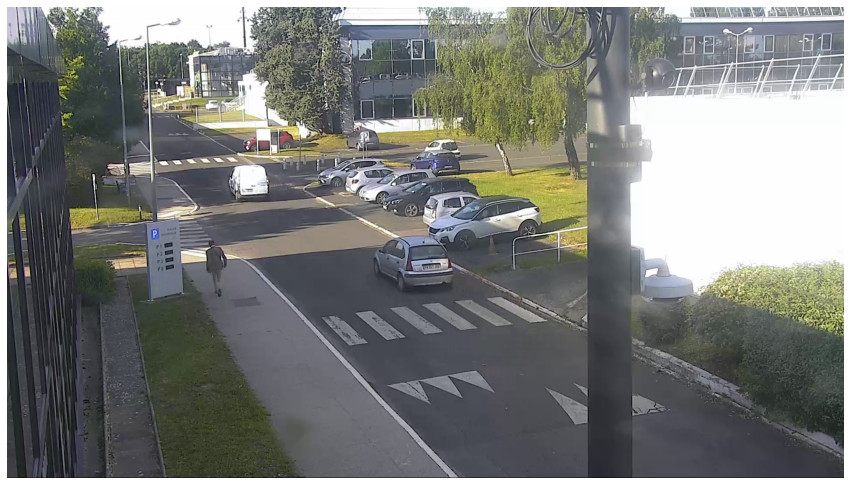

In [147]:
test_img = get_frame(filepath, get_it = 1, speed = 1000)

In [148]:
pred_filtered = analyse_prediction(preds0[1], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6,14], ul_lim = (445,0), lr_lim = None)

****
Object:car
Confidence 0.58954256772995 
Upper left: (852.9574012756348 534.9232292175293)
Lower right: (1022.0417404174805 648.6096954345703)
****
Object:person
Confidence 0.20032043755054474 
Upper left: (447.2174263000488 535.7306671142578)
Lower right: (524.479808807373 649.2704772949219)
******
Found 1 objects from class car
Found 1 objects from class person


In [149]:
car_predictions = [p for p in pred_filtered if p[-1] == 6]

In [150]:
ppl_predictions = [p for p in pred_filtered if p[-1] == 14]

In [179]:
import math

In [183]:
math.degrees(np.arctan(1))

45.0

In [184]:
def get_object_pos(obj_img_coords, camera_altitude, camera_tilt, fl_w, fl_h):
    """
     calculate object coordinates in the plane projected onto image
    :obj_img_coords: image coordinates of object 
    :fl_w: width focal lenght
    :fl_h: heigth focal lenght
    :return: relative coordinates to camera plane
    """ 
    theta_2 = math.degrees(np.arctan(abs(obj_img_coords[1] - cam_center[1])/fl_w))
    tan_2 = np.tan(math.rad(theta_2))
    # calculate distance from car to camera
    I = camera_altitude/tan_theta_2

    tan_theta_1 = (abs(obj_img_coords[0]-cam_center[0])/fl_h)

    # calculate distance from car centralm camera axis
    J = tan_theta_1*I

    return [I,J]

In [153]:
def get_bb_center(bb):
    """
     calculate object center based upon it's bounding box coordinates
    :bb: image coordinates of bounding box are assumed to be first 4 entries of bb
    :return: center of bounding box 
    """     
    ul = (bb[0], bb[1])
    lr = (bb[2], bb[3])
    center_coord = ( ul[0] + (lr[0] - ul[0])/2, ul[1] + (lr[1] - ul[1])/2)
    return center_coord

In [154]:
def plot_object_center(img, prediction, figsize = (10,10)):
    plt.figure(figsize=figsize)
    
    
    # plot bbox
    plt.plot(prediction[0],prediction[1], 'x', c = 'y', markersize = '10')
    plt.plot(prediction[2],prediction[3], 'x', c = 'y', markersize = '10')
    
    
    # plot bbox center
    center_coords = get_bb_center(prediction)
    plt.plot(center_coords[0],center_coords[1], 'o', c = 'r', markersize = '10')

    plt.imshow(img)
    plt.show()

# Cam params

**Lens** 4.44-142.6 mm, F1.6-4.41

**Horizontal angle of view:** 62.8˚- 2.23˚

**Vertical angle of view:** 36.8˚- 1.3˚

**Camera position:** Needs validation

In [169]:
# eps is an approximation of the camera captor size in real world
eps = 1e-3

# camera resolution in pixels
height_res = 1920 # Image width in pixels
widht_res = 1080 # Image height in pixels

# center of image (in image coordinates)
cam_center =  (height_res/2, widht_res/2)

# field of view in degrees
fov_h = 62.8 # FOV in degrees
fov_w = 36.8 # FOV in degrees

# camera tilt in degrees
w = 10.0

# camera altitude
camera_altitude = 5

# calculate the focal lenght
fl_h = (height_res/2)/(np.tan(np.deg2rad(fov_h/2)))
fl_w = (widht_res/2)/(np.tan(np.deg2rad(fov_w/2)))

# coordinates of the camera in real world
camera_coords = (0, 0)

In [170]:
get_object_pos(get_bb_center(car_predictions[0]), camera_altitude, fl_w, fl_h)

[156.7906917864295, 2.2431391980947195]

In [171]:
get_object_pos(get_bb_center(ppl_predictions[0]), camera_altitude, fl_w, fl_h)

[154.59830433482225, 46.60868971935776]

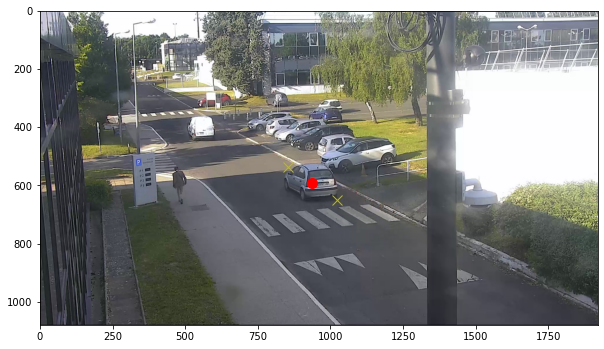

In [172]:
plot_object_center(test_img,car_predictions[0])

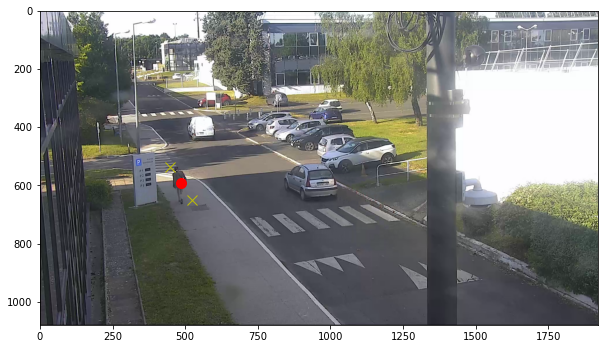

In [173]:
plot_object_center(test_img,ppl_predictions[0])

# Validating results: projecting points on image

